# Comparing Classifiers
## Banking Marketing Campaign Results

## Business Problem:
Evaluate the performance of different classifiers using a bank marketing dataset.

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import process_time
from matplotlib.ticker import PercentFormatter

# sklearn model pipelining and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# sklearn models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## 1. Preliminary Data Mining

In [5]:
bank_full = pd.read_csv('data/bank-additional-full.csv', sep = ';')
print(bank_full.head())
print(bank_full.info())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

## About the Dataset
https://archive.ics.uci.edu/dataset/222/bank+marketing

From the data source:
"The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed."

In [6]:
print(bank_full.value_counts('loan'))

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64


In [7]:
X = bank_full.drop(['duration','y'], axis = 1)
y = bank_full['y']
# Dropping duration as instructed by dataset description here: https://archive.ics.uci.edu/dataset/222/bank+marketing

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [9]:
## Benchmarking:
print(y.value_counts(normalize=True))

dummy_clf = DummyClassifier().fit(X_train, y_train)
baseline_score = dummy_clf.score(X_test, y_test)

print(baseline_score)

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64
0.8880256385354958


In [30]:
model_setup_dtree = {
    'name':'dtree',
    'param_dict':{'dtree__max_depth':[1,2,3,4,5,7,10,15,20,25]},
    'model':DecisionTreeClassifier()
}
print(model_setup_dtree)

model_setup_logreg = {
    'name':'logreg',
    'param_dict': {
        'logreg__penalty': ['l2',None],
        'logreg__random_state': [42]
    },
    'model': LogisticRegression()
}

model_setup_KNN = {
    'name':'KNN',
    'param_dict': {
        'KNN__n_neighbors':[1,2,3,4,5,10,15,20,25,30,40,50,60,75,100,150,250,500],
        'KNN__weights':['uniform', 'distance']
    },
    'model': KNeighborsClassifier()
}

model_setup_SVM_linear = {
    'name':'SVM_linear',
    'param_dict': {
        'SVM_linear__kernel':['linear'],
    },
    'model': SVC()
}

model_setup_SVM_poly = {
    'name':'SVM_poly',
    'param_dict': {
        'SVM_poly__kernel':['poly'],
        'SVM_poly__gamma':[1],
        'SVM_poly__degree':[2,3,6],
        'SVM_poly__coef0':[1.0]
    },
    'model': SVC()
}

model_setup_SVM_rbf = {
    'name':'SVM_rbf',
    'param_dict': {
        'SVM_rbf__kernel':['rbf'],
        'SVM_rbf__gamma':[0.001, 0.01, 0.1, 1, 10],
    },
    'model': SVC()
}

{'name': 'dtree', 'param_dict': {'dtree__max_depth': [1, 2, 3, 4, 5, 7, 10, 15, 20, 25]}, 'model': DecisionTreeClassifier()}


In [82]:
def run_grid(model_setup, N_JOBS = 1, N_CV = 5):

    start = process_time()
    
    # Build a Preprocessor that one hot encodes categorical variables
    cat_features = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    preprocessor = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output = False), cat_features)
        ],
        remainder = 'passthrough'
    )

    # Make Pipeline
    pipe = Pipeline([
        ('preprocessor',preprocessor),
        ('scaler',StandardScaler()),
        (model_setup.get('name'), model_setup.get('model'))
        ])

    # Fit Grid on all params
    grid = GridSearchCV(estimator = pipe,
                        param_grid = model_setup.get('param_dict'),
                       cv = N_CV,
                       n_jobs = N_JOBS)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_train_preds = best_model.predict(X_train)
    y_test_preds = best_model.predict(X_test)

    # Save stuff to a dataframe (best params, fit time, scores)
    res_dict = {'model': [model_setup.get('name')],
                'best_params': [grid.best_params_],
                'best_score': [grid.best_score_],
                'fit time': [grid.refit_time_],
               'train score': [grid.score(X_train, y_train)],
               'test score': [grid.score(X_test, y_test)],
                'accuracy_train': [accuracy_score(y_train_preds, y_train)],
               'accuracy_test': [accuracy_score(y_test_preds, y_test)],
                'precision_train': [precision_score(y_train_preds, y_train, pos_label='yes')],
               'precision_test': [precision_score(y_test_preds, y_test, pos_label='yes')],
                'recall_train': [recall_score(y_train_preds, y_train, pos_label='yes')],
               'recall_test': [recall_score(y_test_preds, y_test, pos_label='yes')],
                'f1_train': [f1_score(y_train_preds, y_train, pos_label='yes')],
               'f1_test': [f1_score(y_test_preds, y_test, pos_label='yes')]
               }
    res_df = pd.DataFrame(res_dict)

    end = process_time()

    print('total time to run: ',end - start)
    
    return(res_df, best_model)

In [83]:
results_dtree, _ = run_grid(model_setup_dtree, N_JOBS = 2)
results_dtree

total time to run:  0.8926790000000437


,model,best_params,best_score,fit time,train score,test score,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
0,dtree,{'dtree__max_depth': 3},0.900036,0.084228,0.9001,0.899291,0.9001,0.899291,0.19501,0.191674,0.709072,0.677914,0.305893,0.298851


In [84]:
results_logreg, model_logreg = run_grid(model_setup_logreg, N_JOBS = 4)
results_logreg

total time to run:  7.283542000000125


,model,best_params,best_score,fit time,train score,test score,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
0,logreg,"{'logreg__penalty': None, 'logreg__random_stat...",0.899226,0.262595,0.900327,0.899874,0.900327,0.899874,0.232865,0.225499,0.667763,0.653266,0.345312,0.335268


In [85]:
results_KNN, model_KNN = run_grid(model_setup_KNN, N_JOBS = 2)
results_KNN

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


total time to run:  32.4216720000004


,model,best_params,best_score,fit time,train score,test score,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
0,KNN,"{'KNN__n_neighbors': 30, 'KNN__weights': 'unif...",0.898158,0.057213,0.900036,0.899,0.900036,0.899,0.215085,0.196878,0.681199,0.665689,0.32694,0.303882


In [61]:
results_SVM_linear, model_SVM_linear = run_grid(model_setup_SVM_linear, N_JOBS = 8, N_CV = 3)
results_SVM_linear

total time to run:  854.8990649999996


,model,best_params,best_score,fit time,train score,test score,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
0,SVM_linear,{'SVM_linear__kernel': 'linear'},0.897834,810.620267,0.897834,0.896572,0.897834,0.896572,0.207915,0.209887,0.6479,0.611111,0.314807,0.31246


In [62]:
# run_grid(model_setup_SVM_poly, N_JOBS = 8, N_CV = 3)

In [63]:
results_SVM_rbf, model_SVM_rbf = run_grid(model_setup_SVM_rbf, N_JOBS = 8)
results_SVM_rbf

total time to run:  75.51035299999967


,model,best_params,best_score,fit time,train score,test score,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
0,SVM_rbf,"{'SVM_rbf__gamma': 0.01, 'SVM_rbf__kernel': 'r...",0.899162,25.994102,0.904147,0.899971,0.904147,0.899971,0.232291,0.213356,0.740402,0.666667,0.353635,0.323259


In [69]:
results_all = pd.concat([results_dtree, results_logreg, results_KNN, results_SVM_linear, results_SVM_rbf], ignore_index = True)
results_all.to_csv('raw_results/results_all_1.csv')
results_all

,model,best_params,best_score,fit time,train score,test score,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
0,dtree,{'dtree__max_depth': 4},0.900036,0.103894,0.901330,0.899388,0.901330,0.899388,0.200746,0.196010,0.728408,0.674627,0.314748,0.303763
1,logreg,"{'logreg__penalty': None, 'logreg__random_stat...",0.899226,0.400844,0.900327,0.899874,0.900327,0.899874,0.232865,0.225499,0.667763,0.653266,0.345312,0.335268
2,KNN,"{'KNN__n_neighbors': 30, 'KNN__weights': 'unif...",0.898158,0.058815,0.900036,0.899000,0.900036,0.899000,0.215085,0.196878,0.681199,0.665689,0.326940,0.303882
3,SVM_linear,{'SVM_linear__kernel': 'linear'},0.897834,810.620267,0.897834,0.896572,0.897834,0.896572,0.207915,0.209887,0.647900,0.611111,0.314807,0.312460
4,SVM_rbf,"{'SVM_rbf__gamma': 0.01, 'SVM_rbf__kernel': 'r...",0.899162,25.994102,0.904147,0.899971,0.904147,0.899971,0.232291,0.213356,0.740402,0.666667,0.353635,0.323259


# Results and Interpretation

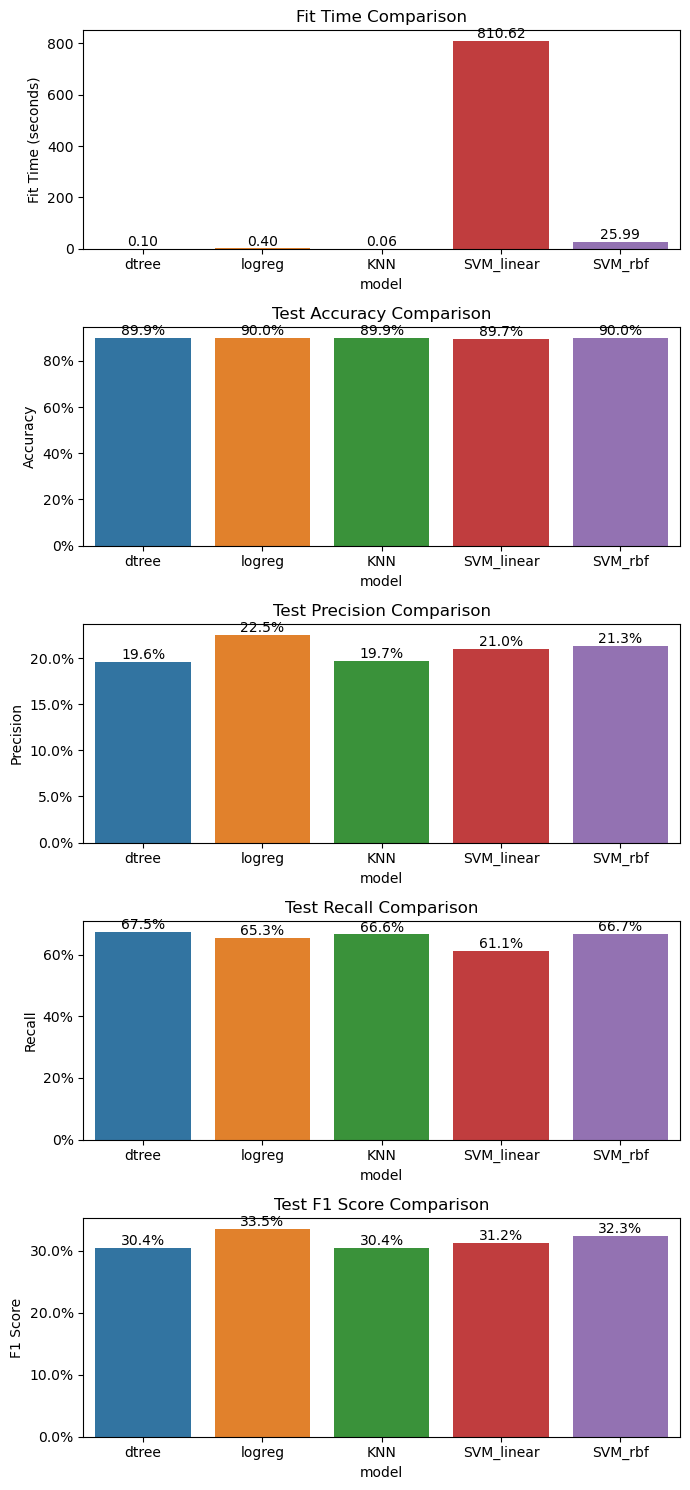

In [80]:
# Clean up the dataframe
data_cleaned = results_all.drop(columns=['best_params', 'best_score', 'train score', 'test score', 'accuracy_train', 'precision_train', 'recall_train', 'f1_train'])
data_cleaned = data_cleaned.rename(columns={'fit time': 'fit_time'})

# Set up the plotting with annotations
fig, ax = plt.subplots(5, 1, figsize=(7, 15))  # Create 5 plots, one for each metric

# Function to add annotations
def add_annotations(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Function to add percentage annotations
def add_percentage_annotations(ax):
    for p in ax.patches:
        percentage = f'{100 * p.get_height():.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Plotting each metric with percentage annotations and formatted y-axis
sns.barplot(x='model', y='fit_time', data=data_cleaned, ax=ax[0])
ax[0].set_title('Fit Time Comparison')
ax[0].set_ylabel('Fit Time (seconds)')
add_annotations(ax[0])

sns.barplot(x='model', y='accuracy_test', data=data_cleaned, ax=ax[1])
ax[1].set_title('Test Accuracy Comparison')
ax[1].set_ylabel('Accuracy')
ax[1].yaxis.set_major_formatter(PercentFormatter(1))
add_percentage_annotations(ax[1])

sns.barplot(x='model', y='precision_test', data=data_cleaned, ax=ax[2])
ax[2].set_title('Test Precision Comparison')
ax[2].set_ylabel('Precision')
ax[2].yaxis.set_major_formatter(PercentFormatter(1))
add_percentage_annotations(ax[2])

sns.barplot(x='model', y='recall_test', data=data_cleaned, ax=ax[3])
ax[3].set_title('Test Recall Comparison')
ax[3].set_ylabel('Recall')
ax[3].yaxis.set_major_formatter(PercentFormatter(1))
add_percentage_annotations(ax[3])

sns.barplot(x='model', y='f1_test', data=data_cleaned, ax=ax[4])
ax[4].set_title('Test F1 Score Comparison')
ax[4].set_ylabel('F1 Score')
ax[4].yaxis.set_major_formatter(PercentFormatter(1))
add_percentage_annotations(ax[4])

plt.tight_layout()
plt.show()

Plots:
1. Fit Time Comparison: This plot shows the time taken by each model to fit the training data. Models with shorter bars are faster.
2. Test Accuracy Comparison: This plot compares the accuracy of each model on the test data.
3. Test Precision Comparison: This plot shows the precision of each model on the test data, which is the ratio of true positive predictions to the total positive predictions made.
4. Test Recall Comparison: This plot compares the recall scores of the models on the test data, indicating the ratio of true positive predictions to the actual positives.
5. Test F1 Score Comparison: This plot shows the F1 scores for each model on the test data, balancing precision and recall.

## Interpretation

Our stated goal was to develop an accurate model that is also easy to fit and interpret. Lets go through all the models from worst to best in thinking about these criteria:

- 6. (Worst) SVM with poly kernel -- took forever / did not finish
- 5. SVM with linear kernel -- decent model with respect to accuracy and F1, but the fit time was orders of magnitude larger than other models. It was the least accurate but the F1 was third best.
- 3. and 4. Decision Trees and KNN. Both of these methods were similarly accurate and with similar F1. Their fit times were extremely low, however their quality with respect to accuracy and F1 wasn't quite to the level of the next two models.
- 2. SVM with rbf kernel: Tied for best accuracy (90.0% and second best F1 (32.3%). Fit time was considerably longer than decision tree and K-Nearest Neighbor methods but worth the accuracy tradeoff.
- **1. Logistic Regression: outperformed all over models with the best accuracy and F1 and a very fast fit time.**

Additional note on model interpretability: Logistic Regression has an advantage over SVM of being much less "black box", and actually being able to provide quantitative probabilities of "Yes" or "No" for each data point. That helps its case as the best model for this use case.

# Next Steps

When time allows, here are some next steps to improve this analysis:

- Improve the Grid Search for the best hyperparameters and models. Figure out why the SVM models (other than rbf) take so long to fit and whether there is a way to speed that up. Perhaps with feature selection so that there are fewer features.
- Feature Selection as a way to (1) Identify the most important feature predictors of "churn", and (2) create a simplified version of the model with only the most important features. The below code shows the most important 10 features identified by the best Logistic Regression model.

In [102]:
feature_names = model_logreg.named_steps['preprocessor'].get_feature_names_out()
coefs = model_logreg.named_steps['logreg'].coef_
coefs_df = pd.DataFrame(zip(feature_names, np.transpose(coefs)), columns=['features', 'coef']) 

print("Most important features: ")
coefs_df.sort_values('coef', key = abs, ascending = False)[0:9]

Most important features: 


,features,coef
57,remainder__emp.var.rate,[-2.434223296972964]
58,remainder__cons.price.idx,[1.2616628938404872]
61,remainder__nr.employed,[0.5708698315968881]
60,remainder__euribor3m,[0.3400339157925549]
55,remainder__pdays,[-0.22533482373539548]
36,ohe__month_aug,[0.21025436742127104]
40,ohe__month_mar,[0.19365725362254113]
34,ohe__contact_telephone,[-0.18944592983468425]
33,ohe__contact_cellular,[0.18944592983468425]
